In [1]:
import astropy
from astropy.table import Table, vstack, Column
from astropy.io import fits
#import dace
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(13)

In [2]:
from utils import *

#### stellar sample

These stars are all HARPS GTO targets (as uniformly characterized by Sousa et al. 2008) with measured vsini (as non-uniformly measured and compiled in Glebocki et al. 2006).

In [3]:
t = Table.read('sousa-vsini-xmatch.vot', format='votable')

<ipython-input-4-1c6ac5748b57>:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(t['Teff'], t['logg'], c=np.log(t['vsini']))


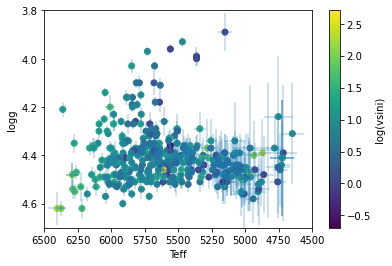

In [4]:
plt.errorbar(t['Teff'], t['logg'], xerr=t['e_Teff'], yerr=t['e_logg'], fmt='none',  alpha=0.3)
plt.scatter(t['Teff'], t['logg'], c=np.log(t['vsini']))
plt.ylim([4.7,3.8])
plt.xlim([6500,4500])
plt.colorbar(label='log(vsini)')
plt.xlabel('Teff')
plt.ylabel('logg');

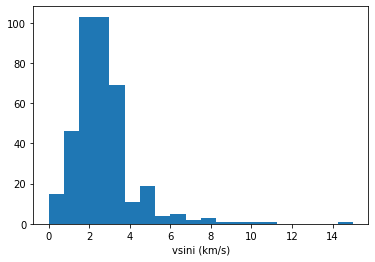

In [5]:
plt.hist(t['vsini'], bins=20)
plt.xlabel('vsini (km/s)');

#### fetch spectra

In [6]:
#stars = np.random.choice(t, 200, replace=False)
stars = t

In [7]:
import glob
specfiles = glob.glob('/Users/mbedell/python/thethethe/harps-data/*/*s1d_A.fits')

In [8]:
targets = []
err_rvs = []
dvrmss = []
snrs = []
exptimes = []
for f in tqdm(specfiles):
    if not os.path.exists(f.replace('s1d', 'postdrs')):
        continue
    wave, flux = read_spectrum(f)
    err_rv = calc_rv_err(wave, flux)
    err_rvs.append(err_rv)
    headerfile = f.replace('s1d', 'postdrs')
    dvrmss.append(get_dvrms(headerfile))
    snrs.append(get_snr(headerfile))
    exptimes.append(get_exptime(headerfile))
    targets.append(get_object(headerfile))

  0%|          | 0/1167 [00:00<?, ?it/s]/Users/mbedell/python/thethethe/utils.py:66: RuntimeWarning: invalid value encountered in true_divide
  err_rv_perpix = err_flux / df_dv
  0%|          | 3/1167 [00:00<01:31, 12.69it/s]/Users/mbedell/python/thethethe/utils.py:66: RuntimeWarning: divide by zero encountered in true_divide
  err_rv_perpix = err_flux / df_dv
100%|██████████| 1167/1167 [01:36<00:00, 12.06it/s]


In [9]:
t['starname'] = [str(s).strip("'").strip("b'").replace(" ", "") for s in t['Star']] # HACKITY HACK HACK

In [10]:
vmags = []
fehs = []
vsinis = []
logg = []
teffs = []
for target,err in zip(targets,err_rvs):
    vmags.append(t[t['starname'] == target]['VMAG'][0])
    fehs.append(t[t['starname'] == target]['__Fe_H_'][0])
    vsinis.append(t[t['starname'] == target]['vsini'][0]) 
    logg.append(t[t['starname'] == target]['logg'][0]) 
    teffs.append(t[t['starname'] == target]['Teff'][0]) 
    #if np.isfinite(t[t['starname'] == target]['precision1'][0]):
    #    t['precision2'][t['starname'] == target] = err
    #else:
    #    t['precision1'][t['starname'] == target] = err

In [11]:
vmags = np.array(vmags)
fehs = np.array(fehs)
vsinis = np.array(vsinis)
err_rvs = np.array(err_rvs)
dvrmss = np.array(dvrmss)
snrs = np.array(snrs)
logg = np.array(logg)
teffs = np.array(teffs)

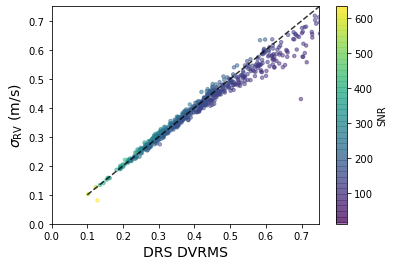

In [12]:
plt.scatter(dvrmss, err_rvs, c=snrs, alpha=0.5, s=12)
plt.xlabel('DRS DVRMS', fontsize=14)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.plot([0.1,1.3],[0.1,1.3], 'k--', alpha=0.8)
plt.xlim([0,0.75])
plt.ylim([0,0.75])
plt.colorbar(label='SNR');

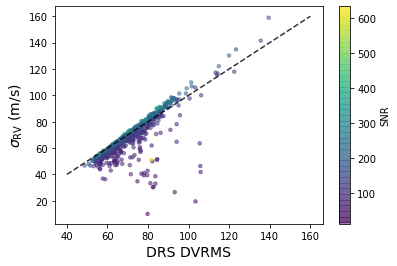

In [13]:
plt.scatter(dvrmss * snrs, err_rvs * snrs, c=snrs, alpha=0.5, s=12)
plt.xlabel('DRS DVRMS', fontsize=14)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.plot([40,160],[40,160], 'k--', alpha=0.8)
plt.colorbar(label='SNR');

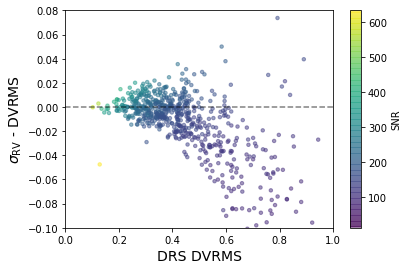

In [14]:
plt.scatter(dvrmss, err_rvs - dvrmss, c=snrs, alpha=0.5, s=12)
plt.axhline(0., c='k', ls='--', alpha=0.5)
plt.xlabel('DRS DVRMS', fontsize=14)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ - DVRMS', fontsize=14)
plt.xlim([0,1])
plt.ylim([-0.1,0.08])
plt.colorbar(label='SNR');

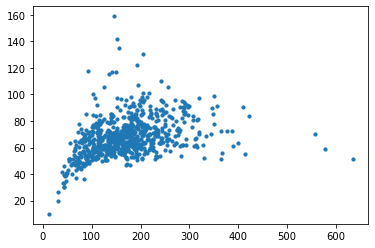

In [15]:
plt.scatter(snrs, np.array(err_rvs) * np.array(snrs), s=10);

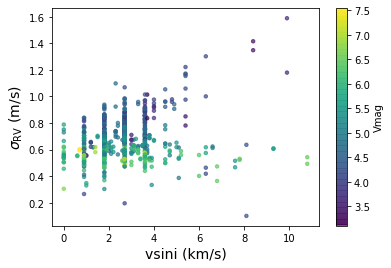

In [16]:
#mask = (teffs > 4500) & (teffs < 5500) & (logg > 4.3) & (snrs >= 100)
#plt.scatter(vsinis[mask], err_rvs[mask] * snrs[mask]/100, c=vmags[mask], alpha=0.7, s=12)
plt.scatter(vsinis, err_rvs * snrs/100, c=vmags, alpha=0.7, s=12)

plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('vsini (km/s)', fontsize=14)
plt.colorbar(label='Vmag');

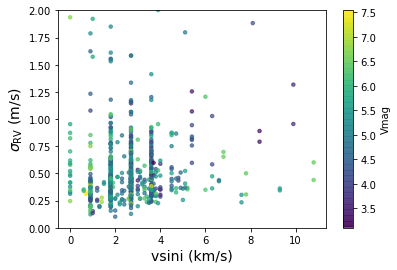

In [17]:
plt.scatter(vsinis, dvrmss, c=vmags, alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('vsini (km/s)', fontsize=14)
plt.ylim([0,2])
plt.colorbar(label='Vmag');

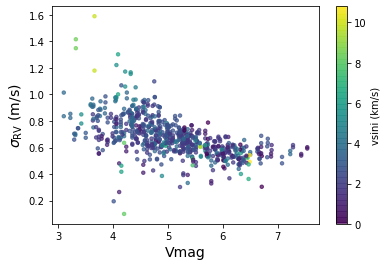

In [18]:
plt.scatter(vmags, err_rvs * snrs/100, c=vsinis, alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('Vmag', fontsize=14)
plt.colorbar(label='vsini (km/s)');

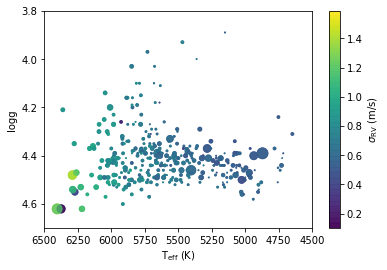

In [19]:
plt.scatter(teffs, logg, c=err_rvs * snrs/100, alpha=0.8, s=vsinis**2)
plt.xlabel(r'T$_{\mathrm{eff}}$ (K)')
plt.ylabel('logg')
plt.xlim([6500,4500])
plt.ylim([4.7,3.8])
plt.colorbar(label=r'$\sigma_{\mathrm{RV}}$ (m/s)');

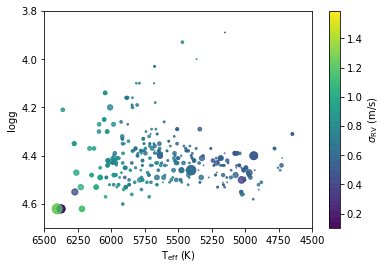

In [20]:
plt.scatter(teffs[::2], logg[::2], c=err_rvs[::2] * snrs[::2]/100, alpha=0.8, s=vsinis[::2]**2)
plt.xlabel(r'T$_{\mathrm{eff}}$ (K)')
plt.ylabel('logg')
plt.xlim([6500,4500])
plt.ylim([4.7,3.8])
plt.colorbar(label=r'$\sigma_{\mathrm{RV}}$ (m/s)');

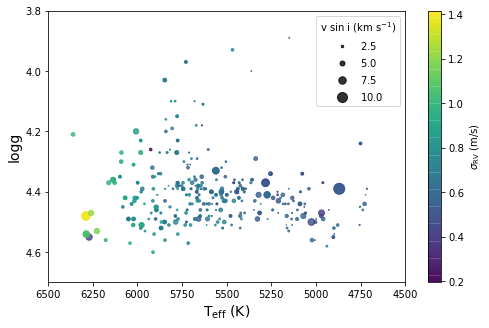

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
scatter = plt.scatter(teffs[1::2], logg[1::2], c=err_rvs[1::2] * snrs[1::2]/100, 
                      alpha=0.8, s=vsinis[1::2]**2)
#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
#legend = plt.legend(handles, labels, loc="upper right", title=r"v sin i (km s$^{-1}$)")
plt.legend(*scatter.legend_elements(prop="sizes", num=5, func=np.sqrt),
          title=r'v sin i (km s$^{-1}$)')
plt.xlabel(r'T$_{\mathrm{eff}}$ (K)', fontsize=14)
plt.ylabel('logg', fontsize=14)
plt.xlim([6500,4500])
plt.ylim([4.7,3.8])
plt.colorbar(label=r'$\sigma_{\mathrm{RV}}$ (m/s)')
plt.savefig('rv-info-content.png');

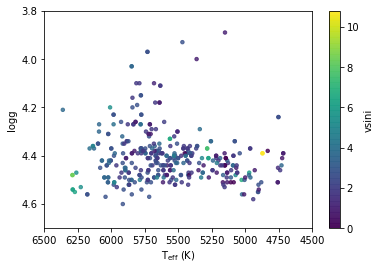

In [22]:
plt.scatter(teffs[1::2], logg[1::2], alpha=0.8, c=vsinis[1::2], s=12)
plt.xlabel(r'T$_{\mathrm{eff}}$ (K)')
plt.ylabel('logg')
plt.xlim([6500,4500])
plt.ylim([4.7,3.8])
plt.colorbar(label='vsini');

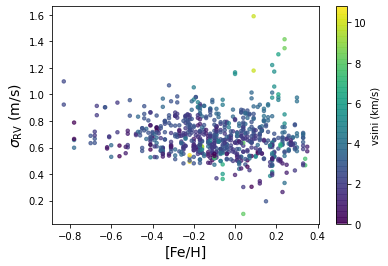

In [23]:
plt.scatter(fehs, err_rvs * snrs/100, c=vsinis, alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('[Fe/H]', fontsize=14)
plt.colorbar(label='vsini (km/s)');

In [28]:
len(np.unique(targets))

353

In [38]:
err_rv_scaled = np.zeros(len(t))
for i,target in enumerate(t['starname']):
    mask = np.array(targets) == target
    err_rv_scaled[i] = np.mean(err_rvs[mask] * snrs[mask]/100)

In [40]:
from astropy.io import ascii
t['err_rv_scaled'] = err_rv_scaled
ascii.write(t, 'gto-with-precision.csv', format='csv', overwrite=True)

#### HERMES spectrum